<h1>Проект «Так закаляем сталь»<span class="tocSkip"></span></h1>


# Описание

Металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали, чтобы оптимизировать производственные расходы. Необходимо построить модель, которая предскажет температуру стали.

**Цель проекта** — металлургическому комбинату ООО «Так закаляем сталь» нужно оптимизировать производственные расходы — уменьшить потребление электроэнергии на этапе обработки стали.

**Задача проекта** — построить модель, которая предскажет температуру стали для технологов.


# Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

# Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc_new.csv` — данные об электродах;
- `data_bulk_new_new.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time_new_new_new.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas_new_new_new_new.csv` — данные о продувке сплава газом;
- `data_temp_new_new_new_new_new.csv` — результаты измерения температуры;
- `data_wire_new_new_new_new_new_new.csv` — данные о проволочных материалах (объём);
- `data_wire_time_new_new_new_new_new_new_new.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.


# Исследовательский анализ

In [2]:
pip install shap

     |████████████████████████████████| 547 kB 1.1 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
import random

from catboost import CatBoostRegressor

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import numpy as np

import pandas as pd

import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import  make_pipeline
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.model_selection import RepeatedKFold, KFold
import shap
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer

In [4]:
data_arc = pd.read_csv('/datasets/data_arc_new.csv')
data_bulk = pd.read_csv('/datasets/data_bulk_new.csv')
data_bulk_time = pd.read_csv('/datasets/data_bulk_time_new.csv')
data_gas = pd.read_csv('/datasets/data_gas_new.csv')
data_temp = pd.read_csv('/datasets/data_temp_new.csv')
data_wire = pd.read_csv('/datasets/data_wire_new.csv')
data_wire_time = pd.read_csv('/datasets/data_wire_time_new.csv')

In [5]:
data_list = [data_arc, data_bulk, data_bulk_time, data_gas, data_temp, data_wire, data_wire_time]
for i in data_list:
    print('\033[1m' + 'Информация' + '\033[0m')
    print(i.info())

Информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
None
Информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    flo

In [6]:
data_list = [data_arc, data_bulk, data_bulk_time, data_gas, data_temp, data_wire, data_wire_time]
for i in data_list:
    print('\033[1m' + 'Описание данных' + '\033[0m')
    print(i.describe())
    print('*'*25)

Описание данных
                key  Активная мощность  Реактивная мощность
count  14876.000000       14876.000000         14876.000000
mean    1615.220422           0.662752             0.438986
std      934.571502           0.258885             5.873485
min        1.000000           0.223120          -715.479924
25%      806.000000           0.467115             0.337175
50%     1617.000000           0.599587             0.441639
75%     2429.000000           0.830070             0.608201
max     3241.000000           1.463773             1.270284
*************************
Описание данных
               key      Bulk 1      Bulk 2       Bulk 3       Bulk 4  \
count  3129.000000  252.000000   22.000000  1298.000000  1014.000000   
mean   1624.383509   39.242063  253.045455   113.879045   104.394477   
std     933.337642   18.277654   21.180578    75.483494    48.184126   
min       1.000000   10.000000  228.000000     6.000000    12.000000   
25%     816.000000   27.000000  242.000000

# Данные об электродах 

In [7]:
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [8]:
data_arc.columns = ['key', 'arc_heating_start', 'arc_heating_finish', 'active_power', 'reactive_power']

In [9]:
data_arc['arc_heating_start'] = pd.to_datetime(data_arc['arc_heating_start'], format='%Y-%m-%d %H:%M:%S')
data_arc['arc_heating_finish'] = pd.to_datetime(data_arc['arc_heating_finish'], format='%Y-%m-%d %H:%M:%S')

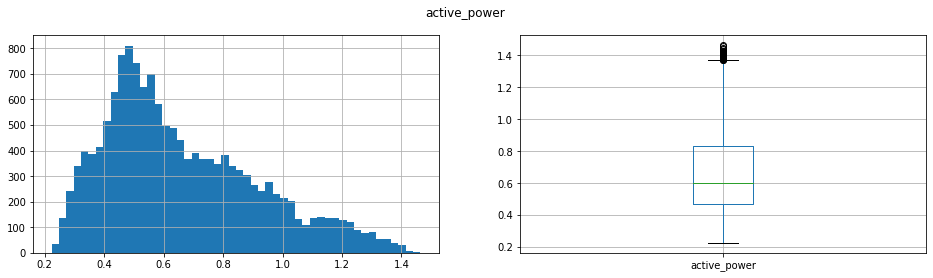

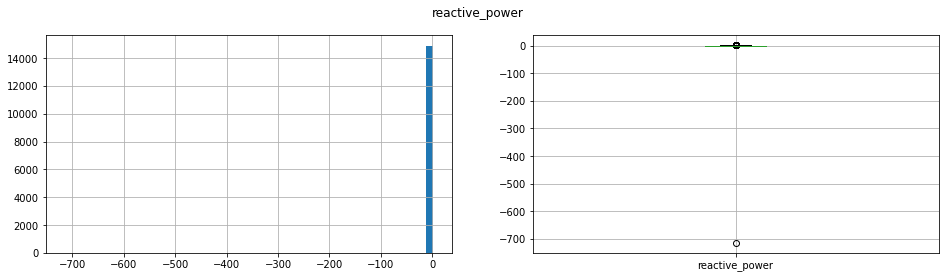

In [10]:
for feature in ['active_power', 'reactive_power']:
    plt.figure(figsize=(16, 4))
    plt.suptitle(feature)

    ax = plt.subplot(1,2,1)
    data_arc[feature].hist(bins=50, ax=ax)

    ax = plt.subplot(1,2,2)
    data_arc.boxplot(column=feature)

Есть выброс в реактивной мощности

In [11]:
data_arc[data_arc['reactive_power'] < -700]

,key,arc_heating_start,arc_heating_finish,active_power,reactive_power
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


In [12]:
data_arc = data_arc[data_arc['key'] != 2116]

# Данные о подаче сыпучих материалов 

In [13]:
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


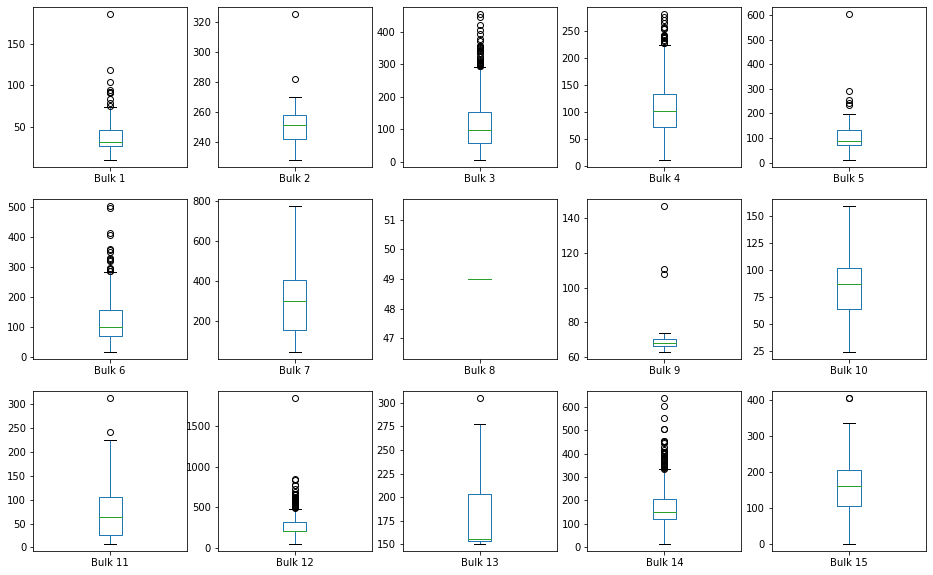

In [14]:
plt.figure(figsize=(16,10))
counter=1
for feature in data_bulk.columns[1:]:
    ax = plt.subplot(3, 5, counter)
    data_bulk.boxplot(column=feature, ax=ax, grid=False)
    counter+=1

Выбросы есть по каждой итерации, но это может быть связано с разным исходным и требуемым составом сплава, а также нужным количеством стали.

In [15]:
data_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


In [16]:
for feature in data_bulk_time.columns[1:]:
    data_bulk_time[feature] = pd.to_datetime(data_bulk_time[feature])

In [17]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   Bulk 1   252 non-null    datetime64[ns]
 2   Bulk 2   22 non-null     datetime64[ns]
 3   Bulk 3   1298 non-null   datetime64[ns]
 4   Bulk 4   1014 non-null   datetime64[ns]
 5   Bulk 5   77 non-null     datetime64[ns]
 6   Bulk 6   576 non-null    datetime64[ns]
 7   Bulk 7   25 non-null     datetime64[ns]
 8   Bulk 8   1 non-null      datetime64[ns]
 9   Bulk 9   19 non-null     datetime64[ns]
 10  Bulk 10  176 non-null    datetime64[ns]
 11  Bulk 11  177 non-null    datetime64[ns]
 12  Bulk 12  2450 non-null   datetime64[ns]
 13  Bulk 13  18 non-null     datetime64[ns]
 14  Bulk 14  2806 non-null   datetime64[ns]
 15  Bulk 15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB


Изменил тип данных даты

In [18]:
df_bulk_melted = data_bulk.melt(id_vars=['key'], value_vars=list(data_bulk.columns[1:]),
                              var_name='bulk_number',
                              value_name='bulk_volume',
                              ignore_index=False).dropna().sort_values(by=['key', 'bulk_number'])


In [19]:
df_bulk_time_melted = data_bulk_time.melt(id_vars=['key'], value_vars=list(data_bulk_time.columns[1:]),
                                        var_name='bulk_number',
                                        value_name='dt_bulk_load',
                                        ignore_index=False).dropna().sort_values(by=['key', 'bulk_number'])

In [20]:
df_bulk_merged = df_bulk_melted.merge(df_bulk_time_melted, how='left', on=['key','bulk_number'])
df_bulk_merged.head(10)

,key,bulk_number,bulk_volume,dt_bulk_load
0,1,Bulk 12,206.0,2019-05-03 11:24:31
1,1,Bulk 14,150.0,2019-05-03 11:14:50
2,1,Bulk 15,154.0,2019-05-03 11:10:43
3,1,Bulk 4,43.0,2019-05-03 11:28:48
4,2,Bulk 12,206.0,2019-05-03 11:53:30
5,2,Bulk 14,149.0,2019-05-03 11:48:37
6,2,Bulk 15,154.0,2019-05-03 11:44:39
7,2,Bulk 4,73.0,2019-05-03 11:36:50
8,3,Bulk 12,205.0,2019-05-03 12:27:13
9,3,Bulk 14,152.0,2019-05-03 12:21:01


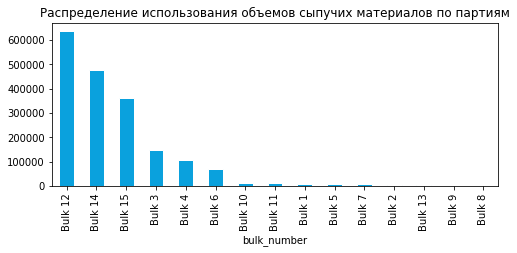

In [21]:
df_bulk_merged.groupby('bulk_number').sum('bulk_volume')['bulk_volume'].\
    sort_values(ascending=False).plot(kind = 'bar', figsize=(8,3), ec='white',
                                      color='#0AA1DD',
                                      title="Распределение использования объемов сыпучих материалов по партиям");

In [22]:
df_bulk_merged = df_bulk_merged[df_bulk_merged['bulk_number'].isin(['Bulk 12', 'Bulk 14', 'Bulk 15', 'Bulk 3',
                                                                    'Bulk 4','Bulk 6'])]

# Данные о продувке сплава газом

In [23]:
data_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [24]:
data_gas.columns = ['key', 'gas']

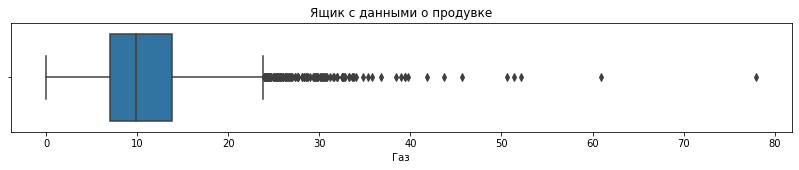

In [25]:
plt.figure(figsize=(14,2))
plt.title('Ящик с данными о продувке',fontsize=12);
sns.boxplot(data=data_gas,x='gas');
plt.xlabel('Газ', fontsize=10);
plt.show()

Проблем не наблюдается

# Результаты измерения температуры

In [26]:
data_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [27]:
data_temp.columns = ['key', 'dt_temp', 'temp']

In [28]:
nan = pd.unique(data_temp[data_temp['temp'].isna()]['key'])
print(f'Доля партий с нулевой температурой:', '{:.1%}'.format(len(nan)/len(pd.unique(data_temp['key']))))

Доля партий с нулевой температурой: 23.0%


In [29]:
data_temp = data_temp.query('key not in @nan')

In [30]:
data_temp['dt_temp'] = pd.to_datetime(data_temp['dt_temp'], format='%Y-%m-%d %H:%M:%S')


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [31]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13926 entries, 0 to 13925
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      13926 non-null  int64         
 1   dt_temp  13926 non-null  datetime64[ns]
 2   temp     13926 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 435.2 KB


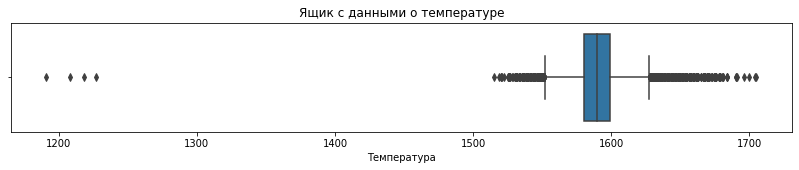

In [32]:
plt.figure(figsize=(14,2))
plt.title('Ящик с данными о температуре',fontsize=12);
sns.boxplot(data=data_temp,x='temp');
plt.xlabel('Температура', fontsize=10);
plt.show()

Есть выбросы меньше 1500

In [33]:
data_temp = data_temp.query('temp > 1400')

# Данные о проволочных материалах

In [34]:
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
data_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
for feature in data_wire_time.columns[1:]:
    data_wire_time[feature] = pd.to_datetime(data_wire_time[feature])

In [37]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   Wire 1  3055 non-null   datetime64[ns]
 2   Wire 2  1079 non-null   datetime64[ns]
 3   Wire 3  63 non-null     datetime64[ns]
 4   Wire 4  14 non-null     datetime64[ns]
 5   Wire 5  1 non-null      datetime64[ns]
 6   Wire 6  73 non-null     datetime64[ns]
 7   Wire 7  11 non-null     datetime64[ns]
 8   Wire 8  19 non-null     datetime64[ns]
 9   Wire 9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


Проблем с данными не наблюдается, единственное изменил тип данных у времени.

In [38]:
df_wire_melted = data_wire.melt(id_vars=['key'], value_vars=list(data_wire.columns[1:]),
                              var_name='wire_number',
                              value_name='wire_volume',
                              ignore_index=False).dropna().sort_values(by=['key', 'wire_number'])


In [39]:
df_wire_time_melted = data_wire_time.melt(id_vars=['key'], value_vars=list(data_wire_time.columns[1:]),
                                        var_name='wire_number',
                                        value_name='dt_wire_load',
                                        ignore_index=False).dropna().sort_values(by=['key', 'wire_number'])

In [40]:
df_wire_merged = df_wire_melted.merge(df_wire_time_melted, how='left', on=['key','wire_number'])
df_wire_merged.head(10)

,key,wire_number,wire_volume,dt_wire_load
0,1,Wire 1,60.059998,2019-05-03 11:06:19
1,2,Wire 1,96.052315,2019-05-03 11:36:50
2,3,Wire 1,91.160157,2019-05-03 12:11:46
3,4,Wire 1,89.063515,2019-05-03 12:43:22
4,5,Wire 1,89.238236,2019-05-03 13:20:44
5,5,Wire 2,9.114560,2019-05-03 13:15:34
6,6,Wire 1,99.109917,2019-05-03 13:57:27
7,6,Wire 2,9.114560,2019-05-03 13:48:52
8,7,Wire 1,98.061600,2019-05-03 14:18:58
9,8,Wire 1,155.282394,2019-05-03 15:01:30


In [41]:
df_wire_merged = df_wire_merged[df_wire_merged['wire_number'].isin(['Wire 1', 'Wire 2'])]

# Выводы

У даты встречается неверный тип данных во всех данных. Также замечены выбросы в некоторых датасетах. Тип данных изменил и выбросы удалены. Названия столбцлов на русском, перевел их на английский.

# План работы
1. Исследовательский анализ данных — загрузка и изучение данных, обработка пропусков, приведение данных к корректному типу, поиск и обработка дубликатов, анализ и обработка аномалий в данных;

2. Подготовка данных — определение и подготовка признаков, разделение данных на выборки, масштабирование;
3. Обучение моделей и валидация — определение целевой метрики, выбор и обучение моделей регрессии, поиск лучшей модели на валидационной выборке;
4. Тестирование моделей — оценка лучшей модели на тестовой выборке;
5. Вывод — описание выполненной работы, общий вывод и рекомендации.

# Предобработка

Создадим новые признаки и агрегируем по номеру партии:

In [42]:
data_arc['full_power'] = np.sqrt(data_arc['active_power'] ** 2 + data_arc['reactive_power'] ** 2)
data_arc = data_arc.drop(columns=['active_power','reactive_power'])
data_arc.head()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,key,arc_heating_start,arc_heating_finish,full_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.371123
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.902319
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.722536
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.642824
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,1.079934


In [43]:
data_arc.insert(3,
              'arc_heating_net_time_sec',
              (data_arc['arc_heating_finish'] - data_arc['arc_heating_start']) / np.timedelta64(1, 's'))
data_arc.head()

,key,arc_heating_start,arc_heating_finish,arc_heating_net_time_sec,full_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,228.0,0.371123
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,185.0,0.902319
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,172.0,0.722536
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,365.0,0.642824
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,148.0,1.079934


In [44]:
data_arc = data_arc.groupby(by='key', axis=0).agg({'arc_heating_start': min,
                                                 'arc_heating_finish': max,
                                                 'arc_heating_net_time_sec': np.sum,
                                                 'full_power': np.average})
data_arc.columns = ['arc_heating_start', 'arc_heating_finish', 'arc_heating_net_time_sec', 'full_power_avg']
data_arc.head()

,arc_heating_start,arc_heating_finish,arc_heating_net_time_sec,full_power_avg
key,,,,
1,2019-05-03 11:02:14,2019-05-03 11:28:37,1098.0,0.743747
2,2019-05-03 11:34:14,2019-05-03 11:53:18,811.0,0.647087
3,2019-05-03 12:06:54,2019-05-03 12:32:19,655.0,1.003845
4,2019-05-03 12:39:37,2019-05-03 12:57:50,741.0,0.850010
5,2019-05-03 13:11:13,2019-05-03 13:33:55,869.0,0.704245


In [45]:
data_arc.insert(3,
              'arc_heating_phase_duration_sec',
              (data_arc['arc_heating_finish'] - data_arc['arc_heating_start']) / np.timedelta64(1, 's'))

In [46]:
data_arc = data_arc.drop(columns=['arc_heating_start','arc_heating_finish'])
data_arc.head()

,arc_heating_net_time_sec,arc_heating_phase_duration_sec,full_power_avg
key,,,
1,1098.0,1583.0,0.743747
2,811.0,1144.0,0.647087
3,655.0,1525.0,1.003845
4,741.0,1093.0,0.850010
5,869.0,1362.0,0.704245


In [47]:
df_bulk = pd.concat([df_bulk_merged.groupby(by='key', axis=0).agg({'bulk_number': 'count',
                                                                     'bulk_volume': np.sum,
                                                                     'dt_bulk_load': min}),
                       df_bulk_merged.groupby(by='key', axis=0).agg({'bulk_number': 'count',
                                                                     'bulk_volume': np.sum,
                                                                     'dt_bulk_load': max}).drop(['bulk_number',
                                                                                                 'bulk_volume'], axis=1)
                      ],
                      axis=1)
df_bulk.columns = ['bulk_count', 'bulk_volume', 'dt_bulk_load_start', 'dt_bulk_load_finish']
df_bulk.head(1)

,bulk_count,bulk_volume,dt_bulk_load_start,dt_bulk_load_finish
key,,,,
1,4,553.0,2019-05-03 11:10:43,2019-05-03 11:28:48


In [48]:
df_bulk['bulk_load_phase_duration_sec'] = (df_bulk['dt_bulk_load_finish'] 
                                               - df_bulk['dt_bulk_load_start']) / np.timedelta64(1, 's')

In [49]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [50]:
data_bulk = pd.merge(df_bulk, data_bulk.drop('Bulk 8', axis=1).set_index('key').fillna(0), on="key")
data_bulk.head()

,bulk_count,bulk_volume,dt_bulk_load_start,dt_bulk_load_finish,bulk_load_phase_duration_sec,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
key,,,,,,,,,,,,,,,,,,,
1,4,553.0,2019-05-03 11:10:43,2019-05-03 11:28:48,1085.0,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
2,4,582.0,2019-05-03 11:36:50,2019-05-03 11:53:30,1000.0,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
3,4,544.0,2019-05-03 12:16:16,2019-05-03 12:32:39,983.0,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
4,4,595.0,2019-05-03 12:43:22,2019-05-03 12:58:00,878.0,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
5,4,584.0,2019-05-03 13:30:47,2019-05-03 13:34:12,205.0,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


In [51]:
data_bulk = data_bulk.drop(columns=['dt_bulk_load_start','dt_bulk_load_finish'])
data_bulk.head()

,bulk_count,bulk_volume,bulk_load_phase_duration_sec,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
key,,,,,,,,,,,,,,,,,
1,4,553.0,1085.0,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
2,4,582.0,1000.0,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
3,4,544.0,983.0,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
4,4,595.0,878.0,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
5,4,584.0,205.0,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


In [52]:
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
df_wire = pd.concat([df_wire_merged.groupby(by='key', axis=0).agg({'wire_number': 'count',
                                                                     'wire_volume': np.sum,
                                                                     'dt_wire_load': min}),
                       df_wire_merged.groupby(by='key', axis=0).agg({'wire_number': 'count',
                                                                     'wire_volume': np.sum,
                                                                     'dt_wire_load': max}).drop(['wire_number',
                                                                                                 'wire_volume'], axis=1)
                      ],
                      axis=1)
df_wire.columns = ['wire_count', 'wire_volume', 'dt_wire_load_start', 'dt_wire_load_finish']

In [54]:
df_wire['wire_load_phase_duration_sec'] = (df_wire['dt_wire_load_finish'] 
                                               - df_wire['dt_wire_load_start']) / np.timedelta64(1, 's')

In [55]:
df_wire.head()

,wire_count,wire_volume,dt_wire_load_start,dt_wire_load_finish,wire_load_phase_duration_sec
key,,,,,
1,1,60.059998,2019-05-03 11:06:19,2019-05-03 11:06:19,0.0
2,1,96.052315,2019-05-03 11:36:50,2019-05-03 11:36:50,0.0
3,1,91.160157,2019-05-03 12:11:46,2019-05-03 12:11:46,0.0
4,1,89.063515,2019-05-03 12:43:22,2019-05-03 12:43:22,0.0
5,2,98.352796,2019-05-03 13:15:34,2019-05-03 13:20:44,310.0


In [56]:
data_wire = pd.merge(df_wire, data_wire.drop('Wire 5', axis=1).set_index('key').fillna(0), on="key")
data_wire.head()

,wire_count,wire_volume,dt_wire_load_start,dt_wire_load_finish,wire_load_phase_duration_sec,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9
key,,,,,,,,,,,,,
1,1,60.059998,2019-05-03 11:06:19,2019-05-03 11:06:19,0.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2,1,96.052315,2019-05-03 11:36:50,2019-05-03 11:36:50,0.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3,1,91.160157,2019-05-03 12:11:46,2019-05-03 12:11:46,0.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4,1,89.063515,2019-05-03 12:43:22,2019-05-03 12:43:22,0.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
5,2,98.352796,2019-05-03 13:15:34,2019-05-03 13:20:44,310.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
data_wire = data_wire.drop(columns=['dt_wire_load_start', 'dt_wire_load_finish'])
data_wire.head()

,wire_count,wire_volume,wire_load_phase_duration_sec,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9
key,,,,,,,,,,,
1,1,60.059998,0.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2,1,96.052315,0.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3,1,91.160157,0.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4,1,89.063515,0.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
5,2,98.352796,310.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
data_temp = pd.concat([data_temp.groupby(by='key', axis=0).agg({'dt_temp': min,
                                                              'temp': 'first'}),
                       data_temp.groupby(by='key', axis=0).agg({'dt_temp': max,
                                                              'temp': 'last'})
                      ],
                      axis=1)
data_temp.columns = ['dt_temp_start', 'temp_first', 'dt_temp_finish', 'temp_last']

In [59]:
data_temp = data_temp.drop(columns=['dt_temp_start','dt_temp_finish'])
data_temp.head()

,temp_first,temp_last
key,,
1,1571.0,1613.0
2,1581.0,1602.0
3,1596.0,1599.0
4,1601.0,1625.0
5,1576.0,1602.0


<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> 

Целевой признак выбран корректно

Создание единого датасета

In [60]:
data = pd.concat([data_arc, data_bulk, data_gas, data_temp, data_wire], axis=1, join='inner').drop(['key'],
                                                                                                   axis=1)
data.head()

,arc_heating_net_time_sec,arc_heating_phase_duration_sec,full_power_avg,bulk_count,bulk_volume,bulk_load_phase_duration_sec,Bulk 1,Bulk 2,Bulk 3,Bulk 4,...,wire_volume,wire_load_phase_duration_sec,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9
1,1098.0,1583.0,0.743747,4,553.0,1085.0,0.0,0.0,0.0,43.0,...,60.059998,0.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2,811.0,1144.0,0.647087,4,582.0,1000.0,0.0,0.0,0.0,73.0,...,96.052315,0.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3,655.0,1525.0,1.003845,4,544.0,983.0,0.0,0.0,0.0,34.0,...,91.160157,0.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4,741.0,1093.0,0.850010,4,595.0,878.0,0.0,0.0,0.0,81.0,...,89.063515,0.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
5,869.0,1362.0,0.704245,4,584.0,205.0,0.0,0.0,0.0,78.0,...,98.352796,310.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0


In [61]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2305 entries, 1 to 2499
Data columns (total 34 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   arc_heating_net_time_sec        2305 non-null   float64
 1   arc_heating_phase_duration_sec  2305 non-null   float64
 2   full_power_avg                  2305 non-null   float64
 3   bulk_count                      2305 non-null   int64  
 4   bulk_volume                     2305 non-null   float64
 5   bulk_load_phase_duration_sec    2305 non-null   float64
 6   Bulk 1                          2305 non-null   float64
 7   Bulk 2                          2305 non-null   float64
 8   Bulk 3                          2305 non-null   float64
 9   Bulk 4                          2305 non-null   float64
 10  Bulk 5                          2305 non-null   float64
 11  Bulk 6                          2305 non-null   float64
 12  Bulk 7                          23

In [62]:
data.describe()

,arc_heating_net_time_sec,arc_heating_phase_duration_sec,full_power_avg,bulk_count,bulk_volume,bulk_load_phase_duration_sec,Bulk 1,Bulk 2,Bulk 3,Bulk 4,...,wire_volume,wire_load_phase_duration_sec,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9
count,2305.000000,2305.000000,2305.000000,2305.000000,2305.000000,2305.000000,2305.000000,2305.000000,2305.000000,2305.000000,...,2305.000000,2305.000000,2305.000000,2305.000000,2305.000000,2305.000000,2305.000000,2305.000000,2305.000000,2305.000000
mean,810.232972,1990.727983,0.825878,3.375271,595.000000,942.382646,3.306725,0.669414,47.822993,37.641649,...,120.849298,176.300217,103.069141,17.780157,3.024398,0.185399,0.796388,0.006427,0.314552,0.313024
std,340.761747,1339.840503,0.160597,1.111882,279.216877,783.612018,12.154499,13.128044,75.552122,58.909093,...,52.630950,290.600479,43.069009,33.752188,27.702457,3.879729,8.116698,0.206772,4.425463,3.456869
min,57.000000,57.000000,0.331897,1.000000,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.918800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,586.000000,1328.000000,0.714380,3.000000,429.000000,478.000000,0.000000,0.000000,0.000000,0.000000,...,88.189919,0.000000,74.131195,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,780.000000,1746.000000,0.818378,4.000000,597.000000,866.000000,0.000000,0.000000,0.000000,0.000000,...,115.227844,0.000000,101.730722,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,995.000000,2397.000000,0.921634,4.000000,778.000000,1286.000000,0.000000,0.000000,81.000000,78.000000,...,150.237362,363.000000,128.185211,23.193039,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,4189.000000,23485.000000,1.572238,5.000000,2644.000000,13683.000000,185.000000,282.000000,454.000000,281.000000,...,425.145752,2351.000000,330.314424,282.780152,385.008668,113.231044,180.454575,8.490040,102.762401,62.025600


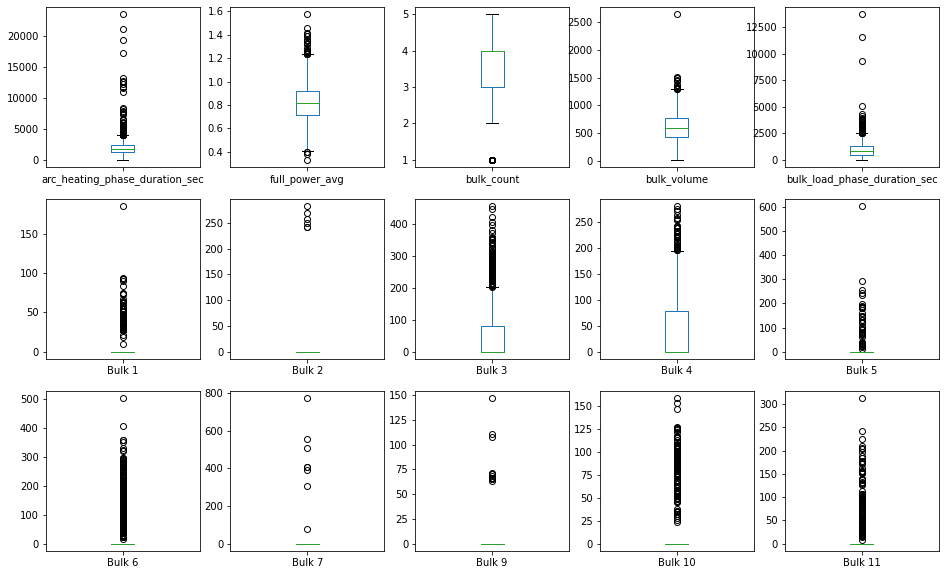

In [63]:
plt.figure(figsize=(16,10))
counter=1
for feature in data.columns[1: 16]:
    ax = plt.subplot(3, 5, counter)
    data.boxplot(column=feature, ax=ax, grid=False)
    counter+=1

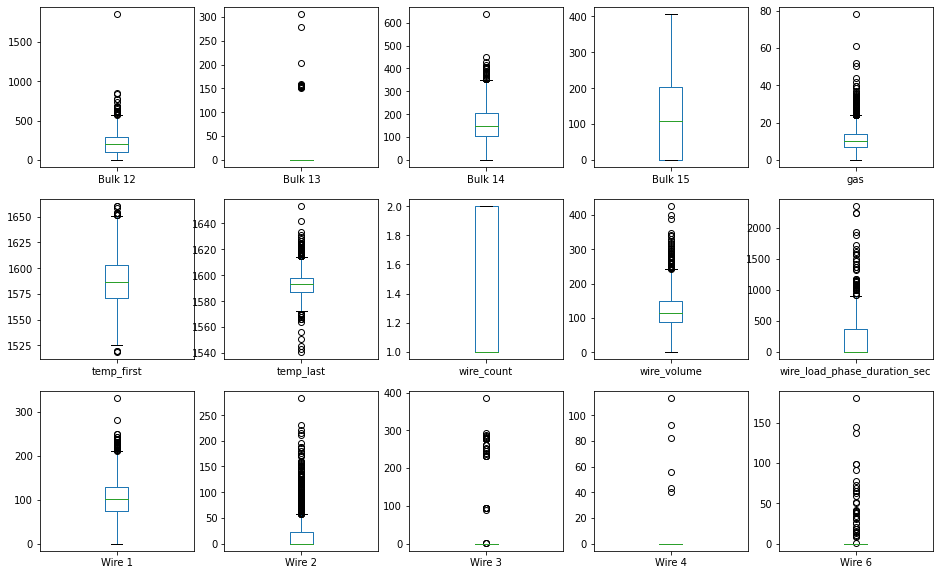

In [64]:
plt.figure(figsize=(16,10))
counter=1
for feature in data.columns[16: 31]:
    ax = plt.subplot(3, 5, counter)
    data.boxplot(column=feature, ax=ax, grid=False)
    counter+=1

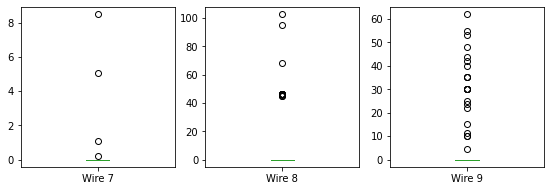

In [65]:
plt.figure(figsize=(16,10))
counter=1
for feature in data.columns[31:]:
    ax = plt.subplot(3, 5, counter)
    data.boxplot(column=feature, ax=ax, grid=False)
    counter+=1

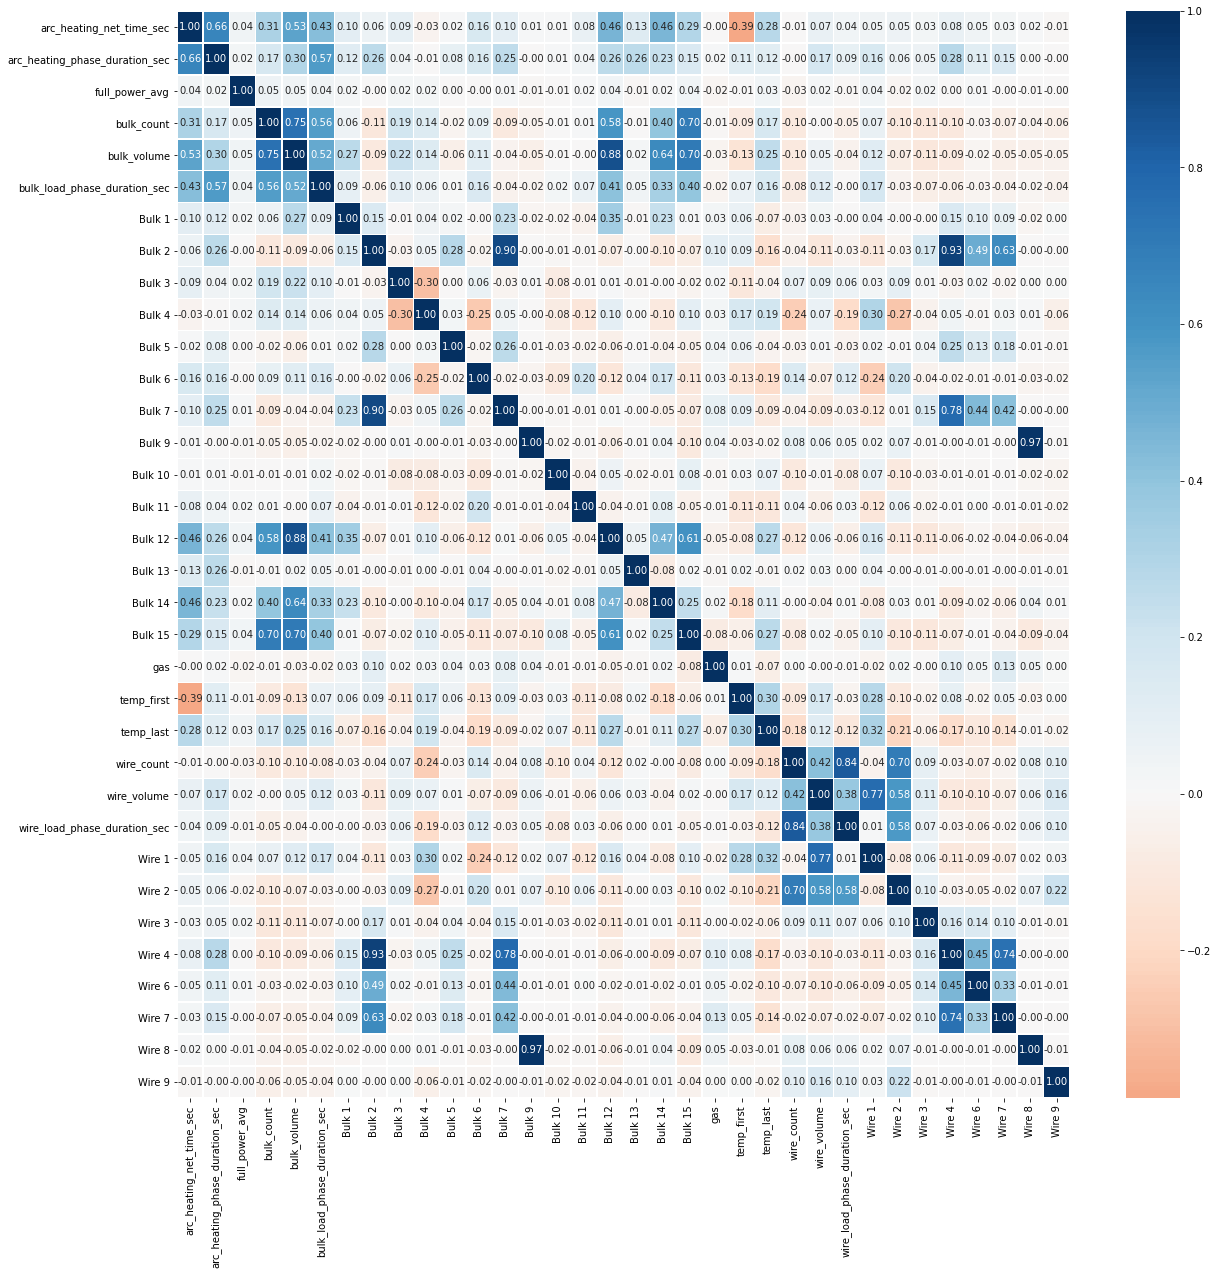

In [66]:
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(data.corr(), center=0, linewidths=.5, annot=True, cmap="RdBu", fmt='.2f', ax=ax);

Чрезмерно коррелирующие между собой признаки наблидаются где корреляция выше 0,9 удалим только один из признаков в абсолютно всех парах высокоскоррелированных признаков для линейной модели

# Обучение

# Разделение выборок

In [67]:
random_state  =  250923

In [68]:
features = data.drop('temp_last', axis=1)
target = data['temp_last']
features_lr = data.drop(['temp_last', 'Bulk 7', 'Wire 4','Bulk 9'] , axis=1)
target_lr = data['temp_last']

In [69]:
features_train, features_test, target_train, target_test = train_test_split(features.copy(), target.copy(), 
                                                                             train_size=0.75, test_size=0.25, 
                                                                             random_state=random_state) 
features_train_lr, features_test_lr, target_train_lr, target_test_lr = train_test_split(features_lr.copy(), target_lr.copy(), 
                                                                             train_size=0.75, test_size=0.25, 
                                                                             random_state=random_state) 

In [70]:
features_train.shape, features_test.shape, target_train.shape, target_test.shape

((1728, 33), (577, 33), (1728,), (577,))

In [71]:
parameters_LR = {}

parameters_DT = {'decisiontreeregressor__max_depth': list(range(1, 51))}

parameters_RF = {'randomforestregressor__max_depth': list(range(50, 250, 50)),
                 'randomforestregressor__n_estimators': list(range(50, 550, 50))}
parameters_LGBM = {'lgbmregressor__num_leaves': list(range(20, 101, 10)),
                 'lgbmregressor__learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5]
                  }
                

model_LR = make_pipeline(StandardScaler(), LinearRegression())
model_DT = make_pipeline(StandardScaler(), DecisionTreeRegressor(random_state=random_state))
model_RF = make_pipeline(StandardScaler(), RandomForestRegressor(random_state=random_state))
model_LGBM = make_pipeline(StandardScaler(), LGBMRegressor(random_state=random_state))


In [72]:
def grid_search_cv(model, features_train, target_train, parameters):
       
    grid = GridSearchCV(estimator=model, param_grid=parameters, cv=5, scoring='neg_mean_absolute_error',
                        n_jobs=-1, error_score='raise')
    
    grid.fit(features_train, target_train)
    mae = grid.best_score_*-1
    best_params = grid.best_params_
    
    print(f'MAE:', round(mae, 2))
    print("Параметры лучшей модели:", best_params)
    print()
    
    return mae

In [73]:
%%time
model = LinearRegression()

mae_LR = (cross_val_score(model, features_train_lr, target_train_lr, cv=5, 
                                          scoring='neg_mean_absolute_error').mean()*-1)

print(f'MAE:', round(mae_LR, 2))

MAE: 5.85
CPU times: user 405 ms, sys: 573 ms, total: 978 ms
Wall time: 897 ms


In [81]:

%%time
mae_DT = grid_search_cv(model_DT, features_train, target_train, parameters_DT)

MAE: 7.13
Параметры лучшей модели: {'decisiontreeregressor__max_depth': 6}

CPU times: user 6.11 s, sys: 1.06 ms, total: 6.11 s
Wall time: 6.11 s


In [82]:

%%time
mae_RF = grid_search_cv(model_RF, features_train, target_train, parameters_RF)

MAE: 6.01
Параметры лучшей модели: {'randomforestregressor__max_depth': 50, 'randomforestregressor__n_estimators': 450}

CPU times: user 10min 39s, sys: 1.51 s, total: 10min 40s
Wall time: 10min 40s


In [101]:
%%time
mae_LightGBM = grid_search_cv(model_LGBM, features_train, target_train, parameters_LGBM)

MAE: 5.77
Параметры лучшей модели: {'lgbmregressor__learning_rate': 0.1, 'lgbmregressor__num_leaves': 20}

CPU times: user 5min 57s, sys: 2.31 s, total: 6min
Wall time: 6min 4s


In [102]:
results_training = pd.DataFrame({'MAE': [mae_LR,
                                         mae_DT,
                                         mae_RF,
                                         mae_LightGBM]},
                                index=['Линейная регрессия', 'Дерево решений',
                                       'Случайный лес', 'LightGBM'])
display(results_training.sort_values(by='MAE'))

,MAE
LightGBM,5.774774
Линейная регрессия,5.839456
Случайный лес,6.007329
Дерево решений,7.127227


Лучший результат показала LightGBM

# Проверка лучшей модели на тестовой выборке

In [103]:
model = LGBMRegressor(random_state=random_state, learning_rate = 0.1, num_leaves = 20)
model.fit(features_train, target_train)
predictions = model.predict(features_test)
MAE_test = round(mean_absolute_error(target_test, predictions), 2)
print(f'MAE test:', round(MAE_test, 2))

MAE test: 6.07


Проверим модель на адекватность

In [104]:
pred_median = np.ones(target_test.shape) * target_train.median() #прогноз медианой
MAE_bench_median = round(mean_absolute_error(target_test, pred_median), 2)
print("MAE bench median:", MAE_bench_median)

MAE bench median: 8.06


Наша модель адекватна так как показала результат лучше чем контакстная

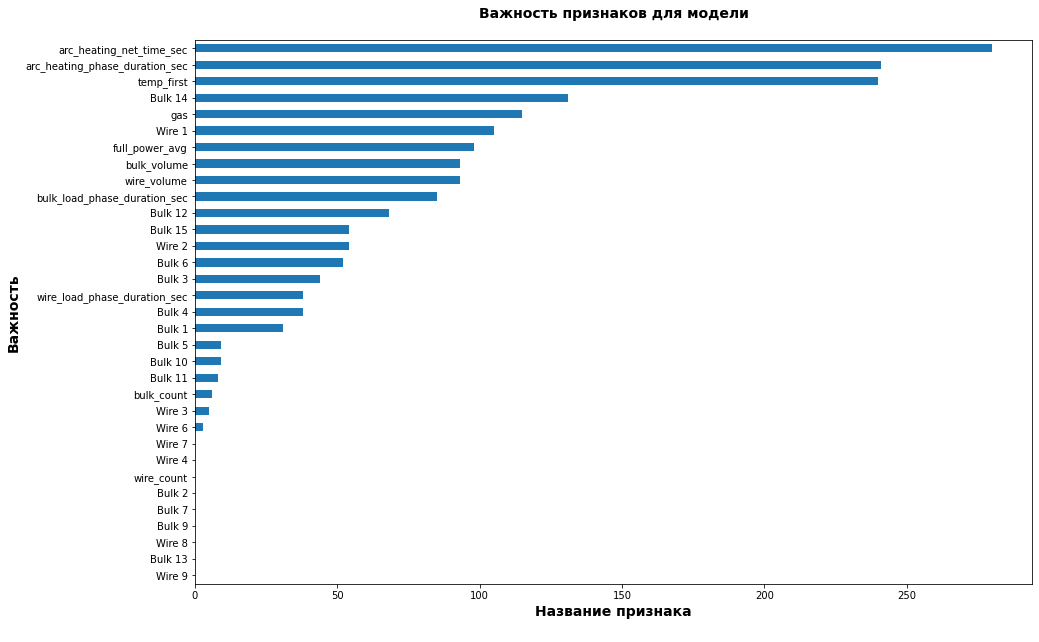

In [106]:
importances = model.feature_importances_
feature_importances = pd.Series(importances, index=features_train.columns)
sorted_importances = feature_importances.sort_values()
sorted_importances.plot(kind='barh', figsize=(15, 10))
plt.xlabel('Название признака\n', fontsize=14, weight='bold')
plt.ylabel('Важность', fontsize=14, weight='bold')
plt.title('Важность признаков для модели\n', fontsize=14, weight='bold')
plt.show()

Признаки были ранжированы по важности, и сильнее всего на целевую переменную влияют параметры и время нагрева, немного меньше - объемы добавленных легирующих компонентов.

**Итоги предобработки**
- Удалены партии, в которых была зафиксирована температура ниже 1400 градусов, в которых нет температуры с финальным замером, и отсутствуют промежуточные замеры 
- Создали новые признаки
- После создания новых признаков, а также после объединения в единый датасет, проверили признаки на корреляцию
- Сгруппировали датасеты по номерам партии - важно, чтоб попали партии, которые были включены на всех этапах обработки. 

**Обучение**
- Провели обучение на следующих моделях: DecisionTreeRegressor, LinearRegression и LGBMRegressor, RandomForestRegressor
- Проверили модель на адекватность с помощью константной модели
- Лучшая метрика при обучении была у модели **LinearRegression - MAE: 5.85**. Причем константная модель дала MAE: 8.27 - это позволяет говорить о целесообразности применения нашей модели LinearRegression для решения задачи заказчика.
- Лучшую модель проверили на тестовой выборке и получили метрику **MAE: 6.25**